In [1]:
%%time
%%capture
!uv pip install feluda
!uv pip install feluda-vid-vec-rep-clip
!uv pip install feluda-dimension-reduction

# other packages
!uv pip install opencv-python
!uv pip install matplotlib

CPU times: user 10.3 ms, sys: 7.21 ms, total: 17.5 ms
Wall time: 1.13 s


In [2]:
import os
import tarfile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from huggingface_hub import hf_hub_download
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from tqdm.notebook import tqdm

from feluda import Feluda
from feluda.models.media_factory import VideoFactory

In [3]:
# Initialize Feluda and the operators
feluda = Feluda("01_plot_tsne_videos_config.yml")
feluda.setup()

dimension_reduction_operator = feluda.operators.get()["dimension_reduction"]
vid_vec_clip_operator = feluda.operators.get()["vid_vec_rep_clip"]

t-SNE model successfully initialized
Installing packages for vid_vec_rep_clip


In [4]:
# Download and extract dataset
if not os.path.exists("UCF101_subset"):
    print("Downloading dataset...")

    file_path = hf_hub_download(
        repo_id="sayakpaul/ucf101-subset",
        filename="UCF101_subset.tar.gz",
        repo_type="dataset",
    )

    with tarfile.open(file_path) as t:
        t.extractall(".")

In [5]:
# Create thumbnails directory
thumbnail_dir = Path("thumbnails")
thumbnail_dir.mkdir(exist_ok=True)

In [6]:
def get_video_thumbnail(video_path):
    """Extract and save thumbnail from video."""
    thumbnail_path = thumbnail_dir / f"{Path(video_path).stem}_thumbnail.jpg"

    # Return existing thumbnail if available
    if thumbnail_path.exists():
        return str(thumbnail_path)

    cap = cv2.VideoCapture(str(video_path))
    ret, frame = cap.read()
    cap.release()

    if ret:
        cv2.imwrite(str(thumbnail_path), frame)
        return str(thumbnail_path)
    return None

In [7]:
def get_all_video_paths(base_dir="UCF101_subset"):
    """Get all video paths recursively."""
    video_paths = []
    for path in Path(base_dir).rglob("*.avi"):
        video_paths.append(str(path))
    return video_paths


# Get all video paths
video_paths = get_all_video_paths()
print(f"Found {len(video_paths)} videos to process")

Found 405 videos to process


In [8]:
%%time
# Process videos and collect embeddings
operator_parameters = []

for video_path in tqdm(video_paths, desc="Processing videos"):
    try:
        # Get video thumbnail
        thumbnail_path = get_video_thumbnail(video_path)

        # Get video embedding
        video = VideoFactory.make_from_file_on_disk(video_path)
        embedding = vid_vec_clip_operator.run(video)
        average_vector = next(embedding)

        operator_parameters.append(
            {
                "payload": video_path,
                "embedding": average_vector.get("vid_vec"),
                "thumbnail_path": thumbnail_path,
            }
        )
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        continue

print(f"Successfully processed {len(operator_parameters)} videos")

Processing videos:   0%|          | 0/405 [00:00<?, ?it/s]

Successfully processed 405 videos
CPU times: user 12.2 s, sys: 692 ms, total: 12.9 s
Wall time: 35.1 s


In [9]:
# Reduce dimensions using operator for plotting t-SNE embeddings
data = dimension_reduction_operator.run(operator_parameters)

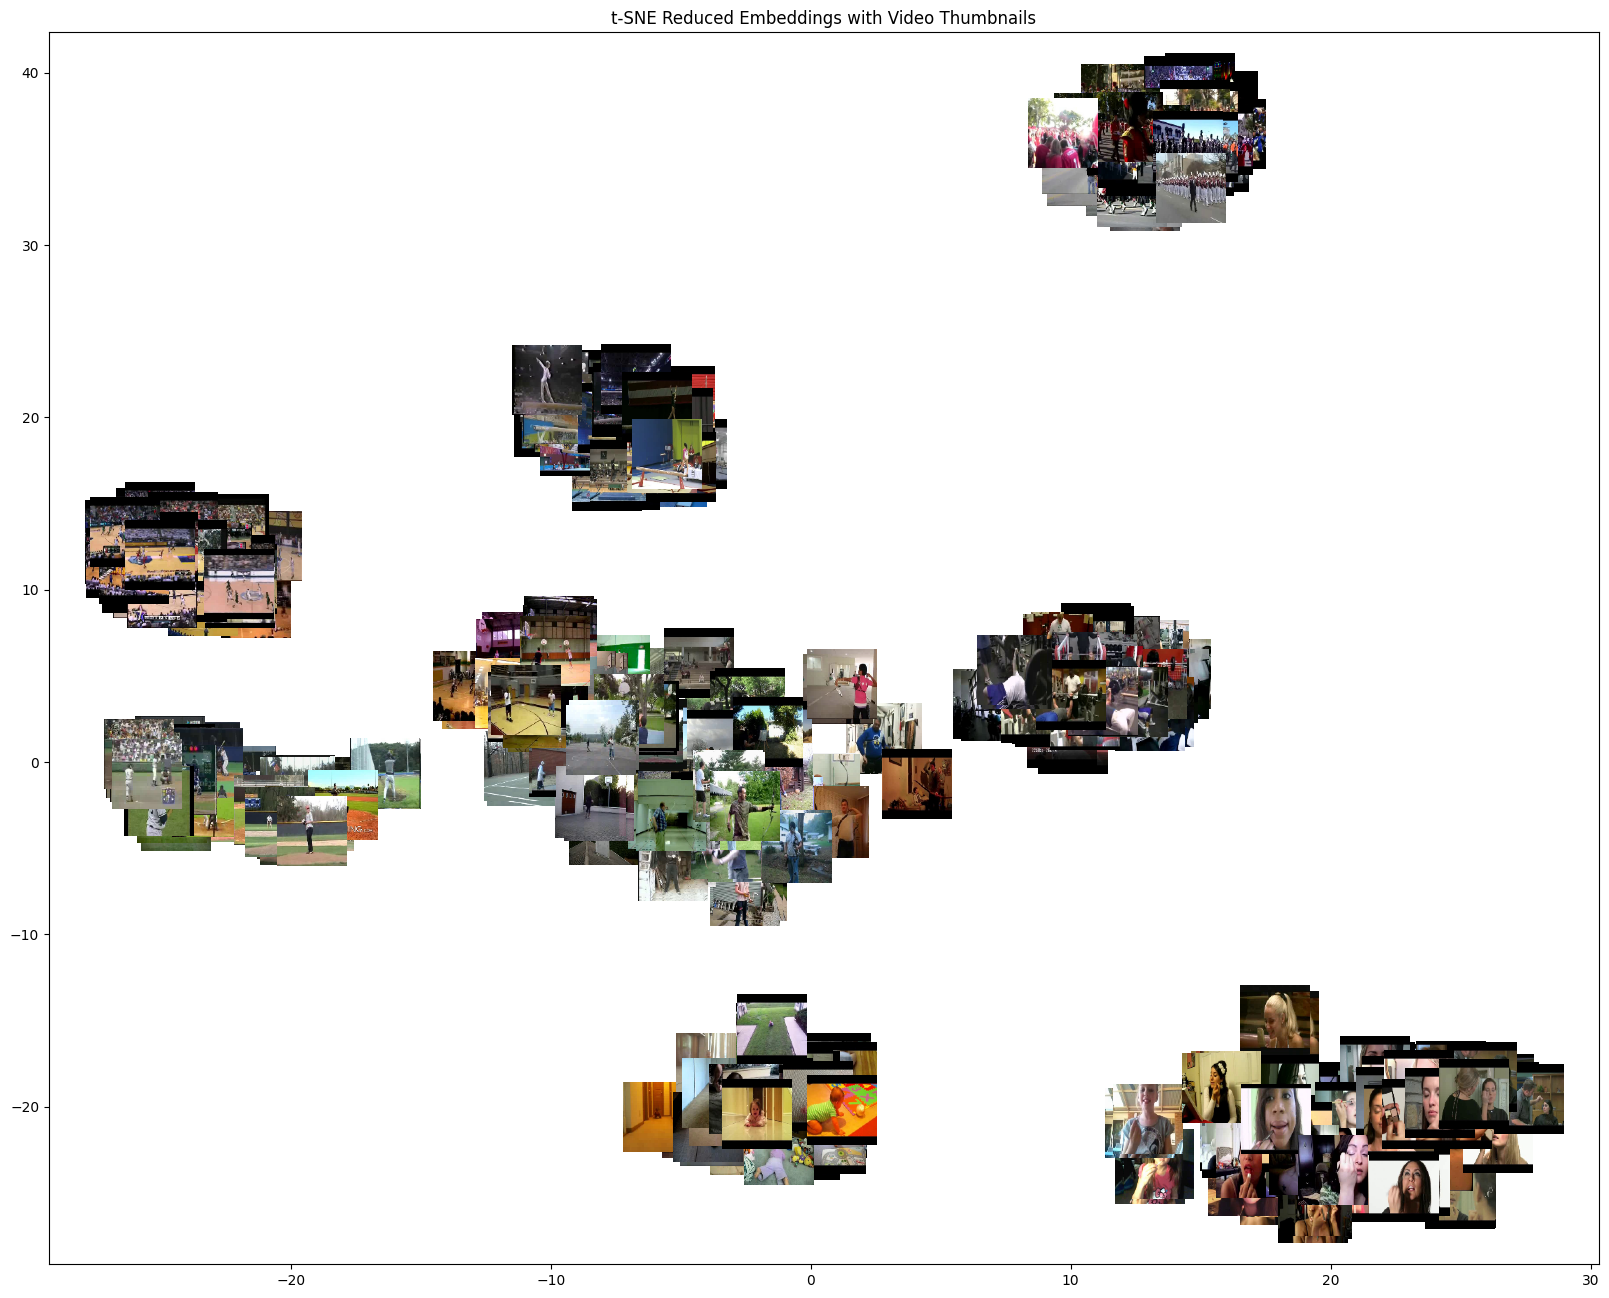

In [10]:
x = np.array([item["reduced_embedding"][0] for item in data])
y = np.array([item["reduced_embedding"][1] for item in data])


def jitter(arr, jitter_amount=0.02):
    return arr + np.random.uniform(-jitter_amount, jitter_amount, arr.shape)


x_jittered = jitter(x, jitter_amount=0.3)
y_jittered = jitter(y, jitter_amount=0.3)

plt.figure(figsize=(20, 16))
plt.scatter(x_jittered, y_jittered)


def load_thumbnail(payload):
    """Load the thumbnail from the pre-saved thumbnail folder."""
    video_filename = os.path.basename(payload)
    thumbnail_filename = video_filename.replace(".avi", "_thumbnail.jpg")
    thumbnail_path = os.path.join(thumbnail_dir, thumbnail_filename)

    if os.path.exists(thumbnail_path):
        return cv2.imread(thumbnail_path)
    else:
        print(f"Thumbnail not found for {video_filename}")
    return None


for i, item in enumerate(data):
    video_thumbnail = load_thumbnail(item["payload"])

    if video_thumbnail is not None:
        video_thumbnail = cv2.resize(video_thumbnail, (100, 100))  # Smaller thumbnails
        video_thumbnail = cv2.cvtColor(video_thumbnail, cv2.COLOR_BGR2RGB)

        # Keep zoom as is, no need for offsets anymore
        imagebox = OffsetImage(video_thumbnail, zoom=0.5)
        ab = AnnotationBbox(
            imagebox, (x_jittered[i], y_jittered[i]), frameon=False
        )  # Use jittered values

        plt.gca().add_artist(ab)

# Set labels and title
plt.title("t-SNE Reduced Embeddings with Video Thumbnails")

plt.show()

In [11]:
# Cleaning cell
import shutil

shutil.rmtree("thumbnails")
shutil.rmtree("UCF101_subset")
os.remove(file_path)

NameError: name 'file_path' is not defined